# Human Protein Atlas Image Classification
## Classify subcellular protein patterns in human cells

In [1]:
import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_style(rc={'font.size': 25})

In [2]:
labels_dict = {0:  'Nucleoplasm', \
          1:  'Nuclear membrane', \
          2:  'Nucleoli', \
          3:  'Nucleoli fibrillar center', \
          4:  'Nuclear speckles', \
          5:  'Nuclear bodies', \
          6:  'Endoplasmic reticulum', \
          7:  'Golgi apparatus', \
          8:  'Peroxisomes', \
          9:  'Endosomes', \
          10:  'Lysosomes', \
          11:  'Intermediate filaments', \
          12:  'Actin filaments', \
          13:  'Focal adhesion sites', \
          14:  'Microtubules', \
          15:  'Microtubule ends', \
          16:  'Cytokinetic bridge', \
          17:  'Mitotic spindle', \
          18:  'Microtubule organizing center', \
          19:  'Centrosome', \
          20:  'Lipid droplets', \
          21:  'Plasma membrane', \
          22:  'Cell junctions', \
          23:  'Mitochondria', \
          24:  'Aggresome', \
          25:  'Cytosol', \
          26:  'Cytoplasmic bodies', \
          27:  'Rods & rings'}

seed = 303

### Dataset preparation

In [3]:
df = pd.read_csv("data/train.csv")
print('We have %d samples!' % len(df)) 
df.head()

We have 31072 samples!


,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [4]:
# Add all labels to dataframe
for key in labels_dict.keys():
    df[labels_dict[key]] = 0


def fill_targets(row):
    row['Target'] = row['Target'].split(' ')

    # Add value 1 to corresponding label 
    for class_ in row['Target']:
        row[labels_dict[int(class_)]] = 1

    return row

df = df.apply(fill_targets, axis=1)
df.head()

,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,"[16, 0]",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,"[7, 1, 2, 0]",1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,[5],0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,[1],0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,[18],0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


## DATA ANALYSIS

### Which classes are the most present?

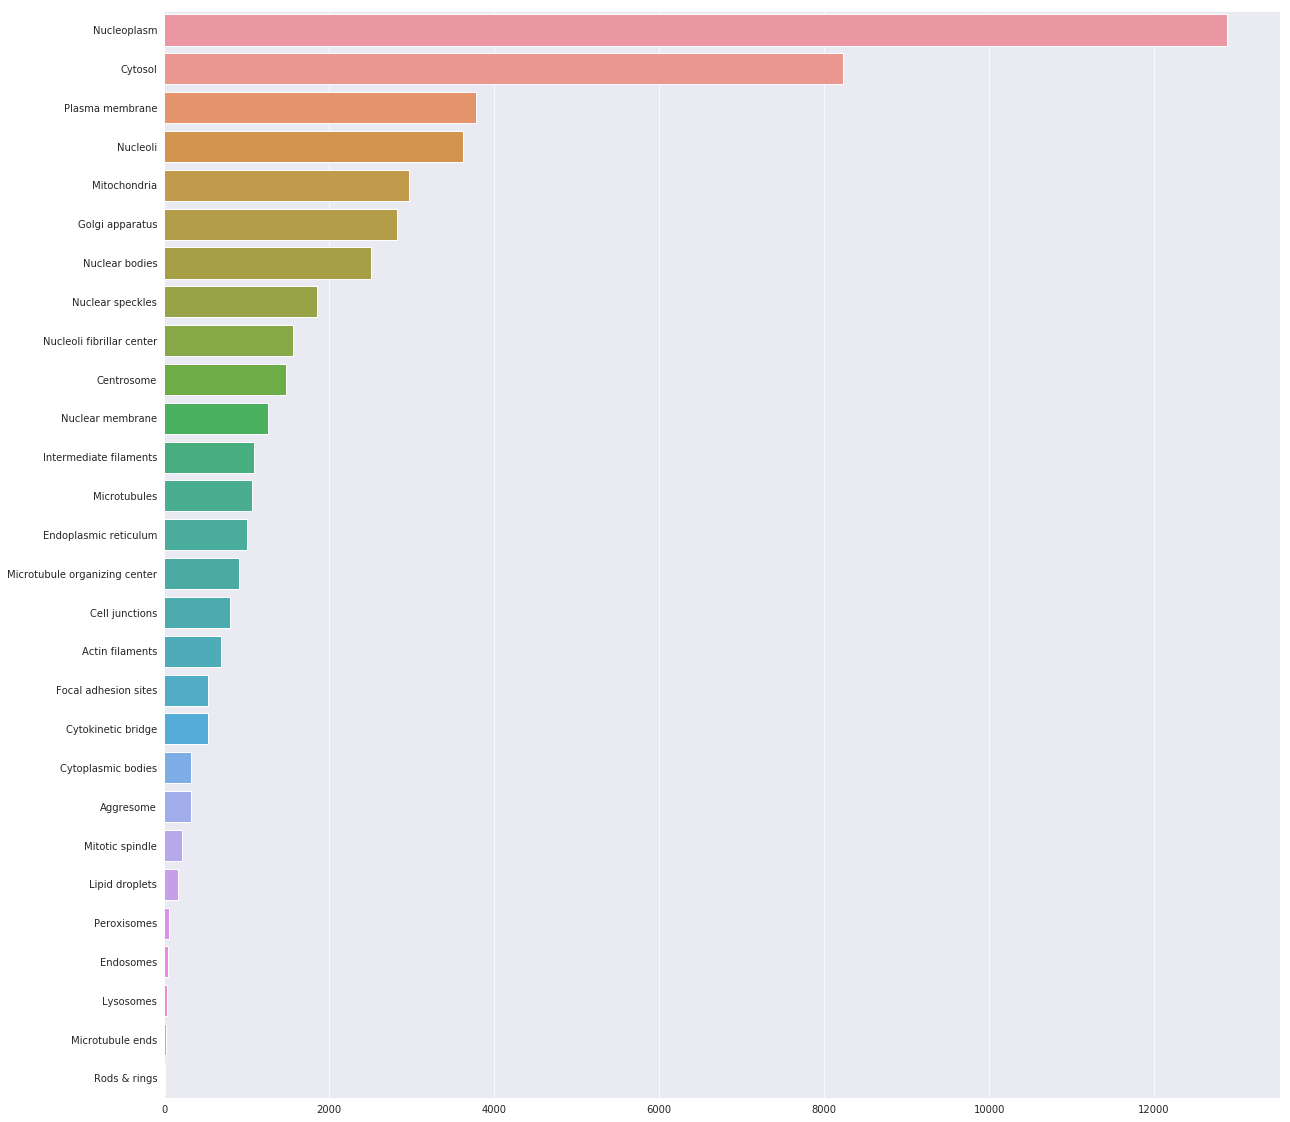

In [5]:
label_counts = df.drop(['Id', 'Target'], axis=1).sum(axis=0).sort_values(ascending=False)

plt.figure(figsize=(20,20))
sns.barplot(y=label_counts.index.values, x=label_counts.values)

- Unbalanced! 

### How many labels per image?

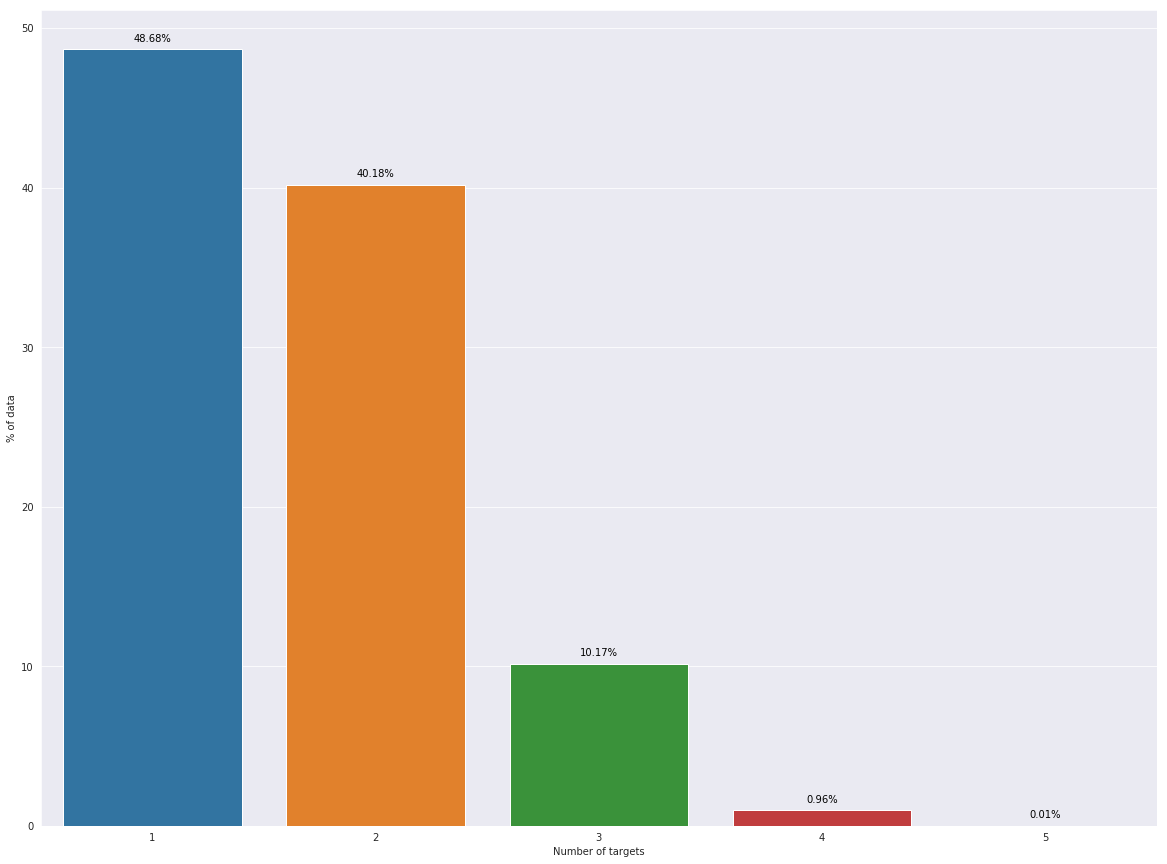

In [6]:
# Counting
df['nb_targets'] = df.drop(['Id', 'Target'], axis=1).sum(axis=1)
count_perc = np.round(100 * df['nb_targets'].value_counts() / df.shape[0], 2)

# Ploting
plt.figure(figsize=(20,15))
sns.barplot(x=count_perc.index.values, y=count_perc.values)

# Annotations
plt.xlabel('Number of targets')
plt.ylabel('% of data')
for idx, value in enumerate(count_perc):
    plt.text(idx, value+0.5, '%.2f%%' % value, color='black', ha="center")

- Most of the images has only one or two labels
- More than three is not common

### Are there any correlations ?

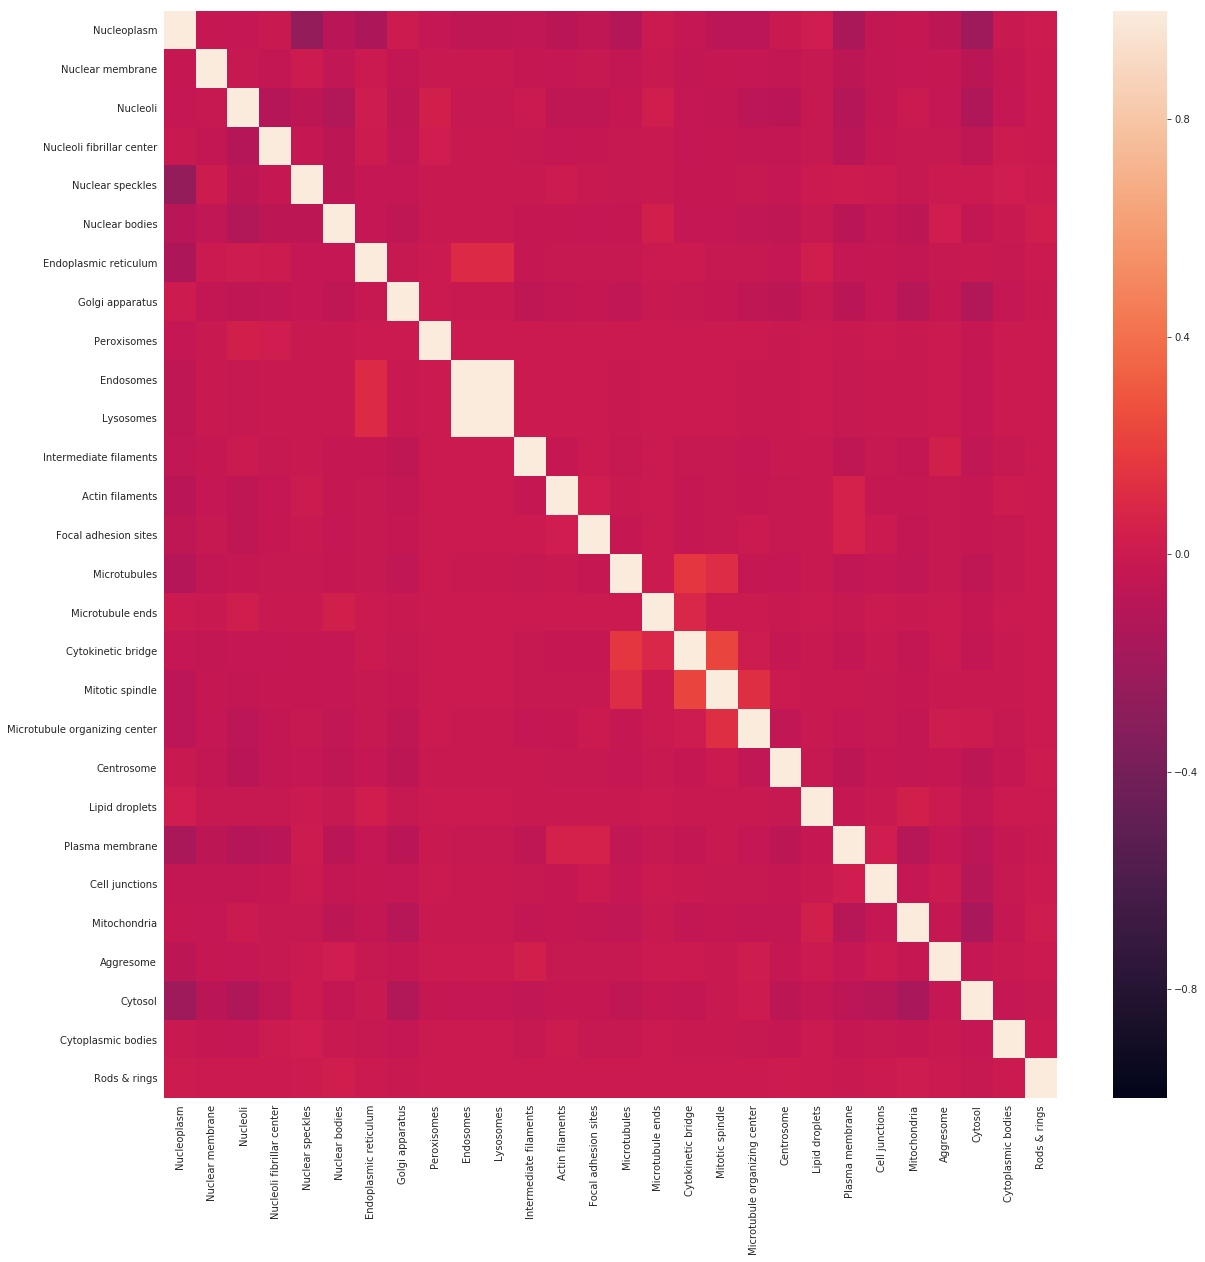

In [7]:
plt.figure(figsize=(20,20))
sns.heatmap(df[df['nb_targets']>1].drop(['Id', 'Target', 'nb_targets'],axis=1).corr(),
            vmin=-1, vmax=1)

- Some target don't have importante correlation with other like Rids & rings

## DATA PREPARATION

### Train and valid set creation

In [8]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, random_state=seed)
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

### Dataset and dataloaders creation

In [9]:
class RGBMultiLabelDataset(Dataset):
    
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform
        
    def get_rgby(id_):
        
        path = 'data/train/%s' % id_
        rgby_img = []
        
        for channel in ('_red.png', '_green.png', '_blue.png', '_yellow.png'):
            rgby_img.append(Image.open(path+channel))
        return Image.merge('RGBA', bands=rgby_img)

    def __getitem__(self, index):
        lbl = self.df.loc[index, 'Target']
        img = get_rgby(self.df.loc[index, 'Id'])

        if self.transform:
            img = self.transform(img)

        return img, label

    def __len__(self):
        return len(self.df)
